### Setup

In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from PIL import Image
import numpy as np
import PIL.ImageOps 
import csv
import zipfile
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Getting the data. Starting with the labels

In [3]:
#TODO!
y_list = []
# /content/drive/MyDrive/malaria_project/Africa_open_access_pruned_14.csv
with open('/content/drive/MyDrive/malaria_project/Africa_open_access_pruned_14.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for i,line in enumerate(csv_reader):
    #np.append(y_labels, line[18])
    if i == 0:
      continue
    y_list.append(float(line[18]))
    #print()
y_labels = np.array(y_list)

In [4]:
len(y_labels)

263

Now we can retrieve the x-data. 

In [5]:
# X_path = "/content/drive/MyDrive/malaria_project/dataset_satellite"
# with zipfile.ZipFile('x_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('x_data')

In [29]:
x_data = []

dir_path = "/content/drive/MyDrive/malaria_project/dataset_satellite" #/content/x_data/x/8.png
for i,image in enumerate(os.listdir(dir_path)):
  if image == ".DS_Store" or image ==".ipynb_checkpoints":
    continue
  # print(image)
  img = Image.open(dir_path+"/"+image)
  img.show()
  
  #crop image
  box = (0, 0, 1024, 1024)
  img = img.crop(box)

  #downscale image to lower resolution #TODO maybe make data generator instead
  img = img.resize((256,256),Image.ANTIALIAS)
 
  
  img2np = np.array(img)
  img2np = img2np[:,:,:3] #removing the alpha dimension
  img2np = img2np.astype('float32')
  img2np /= 255
  #x_data = np.array(img2np)
  x_data.append(img2np)
  #print(img2np.shape)
  #x_data[0] = img2np
x_data = np.array(x_data)


print("Shape:",np.array(x_data).shape)

Shape: (263, 256, 256, 3)


In [30]:
# x_data_big = []

# dir_path = "/content/drive/MyDrive/malaria_project/dataset_satellite" #/content/x_data/x/8.png
# for i,image in enumerate(os.listdir(dir_path)):
#   if image == ".DS_Store" or image ==".ipynb_checkpoints":
#     continue
#   # print(image)
#   img = Image.open(dir_path+"/"+image)
#   img.show()
  
#   #crop image
#   box = (0, 0, 1024, 1024)
#   img = img.crop(box)

#   img2np = np.array(img)
#   img2np = img2np[:,:,:3] #removing the alpha dimension
#   img2np = img2np.astype('float32')
#   img2np /= 255
#   #x_data = np.array(img2np)
#   x_data_big.append(img2np)
#   #print(img2np.shape)
#   #x_data[0] = img2np
# x_data_big = np.array(x_data_big)


# print("Shape:",np.array(x_data_big).shape)

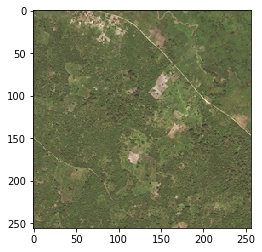

In [31]:
# cutoff = 100
# x_data = x_data[:cutoff]
# y_labels = y_labels[:cutoff]
# print("Shape:",np.array(x_data).shape)
# print(len(y_labels))

# # print(x_data)
# print(y_labels)

plt.imshow(x_data[0], interpolation='nearest')
plt.show()

# plt.imshow(x_data_big[0], interpolation='nearest')
# plt.show()

Sanity check that the pixels intensitity values are within [0,1]

In [32]:
print(img2np.max())

print(img2np.min())

0.92941177
0.0


In [33]:
dataset_size = x_data.shape[0]
x_train = x_data[:int(dataset_size*0.8)]
x_test = x_data[int(dataset_size*0.8):]
print(x_train.shape, x_test.shape)

dataset_size = x_data.shape[0]
y_train = y_labels[:int(dataset_size*0.8)]
y_test = y_labels[int(dataset_size*0.8):]
print(len(y_train), len(y_test))

(210, 256, 256, 3) (53, 256, 256, 3)
210 53


Variables

In [80]:
# img_rows, img_cols= 1024,1024
width = x_data.shape[1]
height = x_data.shape[2]
img_rows, img_cols= height, width
print(img_rows, img_cols)
batch_size = 10
epochs = 50
input_shape = (img_rows, img_cols, 3)

256 256


### Model

Now we can define the CNN model. We use the Sequential which simply is a linear stack of layers.

In [81]:
#inspiration from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb#scrollTo=rsf9rD8I17Wq

tensorflow.random.set_seed(0) # make weight initialization deterministic

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape)) # input_shape is (28, 28, 1)
model.add(Dense(32,activation='relu')) 
model.add(Dense(32,activation='relu')) 
# model.add(Dense(64,activation='relu')) 
model.add(Dense(1)) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 196608)            0         
                                                                 
 dense_12 (Dense)            (None, 32)                6291488   
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,292,577
Trainable params: 6,292,577
Non-trainable params: 0
_________________________________________________________________


Compiling the model

In [82]:
# model.compile(optimizer='sgd',loss='mean_absolute_error',metrics=['accuracy'])
model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.001), loss='mean_absolute_error')

### Training

Fitting the model

In [83]:
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2
            )

Epoch 1/50
17/17 [==============================] - 1s 26ms/step - loss: 9.3711 - val_loss: 1.5716
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 1.1255 - val_loss: 0.2772
Epoch 3/50
17/17 [==============================] - 0s 13ms/step - loss: 1.2720 - val_loss: 3.6037
Epoch 4/50
17/17 [==============================] - 0s 11ms/step - loss: 0.9719 - val_loss: 0.3648
Epoch 5/50
17/17 [==============================] - 0s 13ms/step - loss: 1.0928 - val_loss: 0.2229
Epoch 6/50
17/17 [==============================] - 0s 14ms/step - loss: 0.7038 - val_loss: 1.4924
Epoch 7/50
17/17 [==============================] - 0s 12ms/step - loss: 0.6937 - val_loss: 0.3938
Epoch 8/50
17/17 [==============================] - 0s 11ms/step - loss: 0.6000 - val_loss: 1.4753
Epoch 9/50
17/17 [==============================] - 0s 12ms/step - loss: 1.1520 - val_loss: 2.0147
Epoch 10/50
17/17 [==============================] - 0s 11ms/step - loss: 0.6439 - val_loss: 0.2377
Epoch 11/

Checking the performance

In [84]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score)
# print('Validation accuracy:', score[1])

Validation loss: 0.26975515484809875


###Evaluation

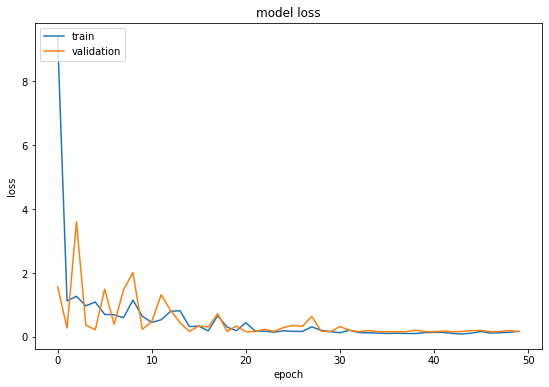

In [85]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  # plt.subplot(121)
  # plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

2/2 [==============================] - 0s 13ms/step
test_predictions [0.11602926 0.10114917 0.14345479 0.11805752 0.1493257  0.08538288
 0.1153672  0.1129925  0.18415728 0.11100087 0.11100087 0.11790961
 0.2503685  0.19831857 0.11170346 0.15890333 0.12633565 0.23801652
 0.13472393 0.1471988  0.08491048 0.29835495 0.14404595 0.26772508
 0.10908958 0.23311076 0.24117938 0.14438534 0.11989558 0.13672489
 0.14274102 0.10289419 0.13550624 0.09343082 0.11354163 0.17121902
 0.07383573 0.21778527 0.1323685  0.19660848 0.16382053 0.21923885
 0.06768152 0.09191719 0.12215531 0.17766097 0.1315116  0.1509533
 0.13450575 0.16391894 0.1082342  0.11468551 0.14132369]
y_test [0.6111 0.5    0.66   0.     0.     0.222  0.0866 0.7879 0.8788 0.75
 0.6429 0.2069 0.1739 0.5    0.2857 0.6    0.619  0.08   0.3636 0.4286
 0.5833 0.45   0.5455 0.3333 0.4444 0.5    0.3913 0.2    0.5556 0.3333
 0.4286 0.4167 0.4    0.7273 0.0769 0.2667 0.4375 0.1429 0.4286 0.75
 0.25   0.9333 0.     0.3684 0.     0.4118 0.0513 0.

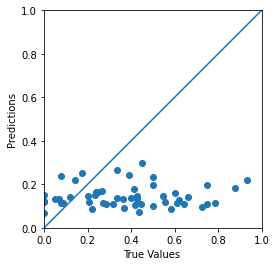

In [86]:
test_predictions = model.predict(x_test).flatten()

print("test_predictions", test_predictions)
print("y_test", y_test)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

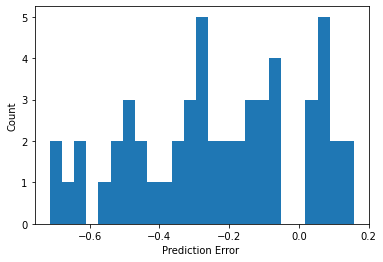

In [87]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')

We can also try to plot the weights

In [42]:
W = model.layers[1].get_weights()[0];
W = W.reshape((1024,1024,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()
  plt.title(f'Row {i} of W')

ValueError: ignored

As can be seen there's a lot of 'random' noisy. We can get rid of this by appplying regularization. We could also just use a lot more data and it should get a better.  

We can try to apply weight decay by making a new model

In [ ]:
lamda = 0.1 #penalty hyper-parameter (is set a rather high so the validation accuracy may decrease)
L2_regularizer = keras.regularizers.l2(lamda)

In [ ]:
# # Model
# model = Sequential()
# model.add(Flatten(input_shape=input_shape))
# model.add(Dense(num_classes,
#                 activation='softmax',
#                 kernel_regularizer=L2_regularizer))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(num_classes,
                activation='softmax',
                kernel_regularizer=keras.regularizers.L1L2(l1=0.0,l2=0.005)))

In [ ]:
# Training
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])
history_reg = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Plotting the weights

In [ ]:
W = model.layers[1].get_weights()[0];
W = W.reshape((28,28,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()
  plt.title(f'Row {i} of W')

### Predict

We can try to make a prediction by (the data might have been used so it's not this impressive)

In [ ]:

predictTest = x_train[59998][None,:,:,0]
print(predictTest.shape)


In [ ]:
predictionOfTest = model.predict(predictTest)

In [ ]:
print(predictionOfTest)

In [ ]:
print("Predicted label:",predictionOfTest.argmax())
print("Accuracy: ",predictionOfTest.max())
plt.imshow(x_train[59998][:,:,0])


###Drawing and predicting the image


Using the gist libery, we can draw in google.colab: https://gist.github.com/8409b3feec20f159d8a50b0a811d3bca.git, I have simply copied the code, since it didn't have a border around the canvas field and added this feature.

In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<style>
  canvas{border:1px solid black;}
</style>
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

In [ ]:
draw(filename = "drawing.png", w=128, h=128, line_width=10)

However since It will save a picture however we will need to do some processing before we can predict what it is.

Since the picture is a .png we need to open it and sinze it 512x512 we also need to reshape it.

In order to predict on it, we need to convert it into a tensor, invert the colors and add a dimension for the number of examples

However we need to do the following processing before we can use for predicting:
1. Convert it to RGB instead of RGBA
1. Resize it to a `28x28` instead of a `512x512`
1. Invert the colors
1. Get the dimensions correct. Here we both needs to remove the RGB color channels and add a dimension for the number of samples.
1. Normalize the data exactly as done in the training process

In [ ]:
#Opening the image
png = Image.open('drawing.png')

#Converting the image to RGB instead of RGBA
png.load() # required for png.split()
rgb_image = Image.new("RGB", png.size, (255, 255, 255))
rgb_image.paste(png, mask=png.split()[3]) # 3 is the alpha channel

#Resizing
rgb_image = rgb_image.resize((28,28)) #Uses PIL to resize

#Converting to numpy object
numpy_image = np.array(rgb_image)

#Inverting black and white
numpy_image = np.invert(numpy_image)

#Removes the channels
numpy_image = numpy_image[:,:,0]

#Plotting the image
plt.imshow(numpy_image)
plt.figure()

In [ ]:
#Adding the dimension for number of example
numpy_image = numpy_image[None,:,:]

Normalization:

In [ ]:
numpy_image = numpy_image.astype('float32')
numpy_image /= 255

Predicting:

In [ ]:
drawedImagePrediction = model.predict(numpy_image)

Result:

In [ ]:
print("predictions:",drawedImagePrediction)
print("Predicted label:",drawedImagePrediction.argmax())
print("Accuracy: ",drawedImagePrediction.max())

### Trying with a CNN model

In [ ]:
# Model
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation

model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4

In [ ]:
print(x_test.shape)

(10000, 28, 28, 1)


In [ ]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Training
history_reg = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 35s 10ms/step - loss: 0.5626 - accuracy: 0.8234 - val_loss: 0.1085 - val_accuracy: 0.9659
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1124 - accuracy: 0.9650 - val_loss: 0.0858 - val_accuracy: 0.9724
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0785 - accuracy: 0.9752 - val_loss: 0.0658 - val_accuracy: 0.9794
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0617 - accuracy: 0.9806 - val_loss: 0.0435 - val_accuracy: 0.9848
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0543 - accuracy: 0.9833 - val_loss: 0.0443 - val_accuracy: 0.9840
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.0383 - val_accuracy: 0.9874
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.0427 - val_accuracy: 0.9851
Epoc

Plotting the weights (See conv_base.summary() for complete list of layer names)

(28, 28, 1)


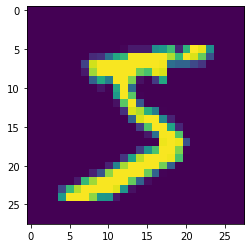

In [ ]:
plt.imshow(x_train[0][:,:,0])
print(x_train[0].shape)

In [ ]:
from keras import Model

def show_feature_maps_from_layer(layer_name,img, layers):
  dummy_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
  out = (dummy_model.predict(img)).squeeze()
  height = out.shape[0]
  width = out.shape[1]
  num_channels = out.shape[2]
  print(f'Feature map size: {height}x{width}x{num_channels}')

  plt.figure(figsize=(16,16))
  for i in range(layers):
    f = out[:,:,i]
    plt.subplot(1,layers,i+1)
    plt.imshow(f,cmap='gray')
    plt.axis('off')
    plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

Feature map size: 14x14x16
Feature map size: 7x7x32


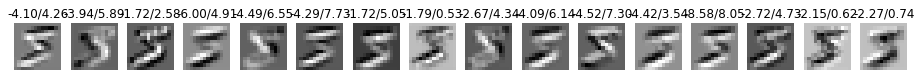

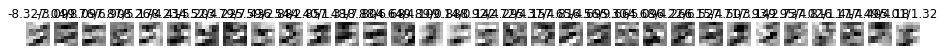

In [ ]:
show_feature_maps_from_layer(layer_name='conv2d_1', img=x_train[0][None,:,:,:], layers=16)
show_feature_maps_from_layer(layer_name='conv2d_2', img=x_train[0][None,:,:,:], layers=32)

In [ ]:
from keras import Model

def show_feature_maps_from_layer(layer_name,img):
  dummy_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
  out = (dummy_model.predict(img)).squeeze()
  height = out.shape[0]
  width = out.shape[1]
  num_channels = out.shape[2]
  print(f'Feature map size: {height}x{width}x{num_channels}')

  plt.figure(figsize=(16,16))
  for i in range(num_channels):
    f = out[:,:,i]
    plt.subplot(1,num_channels,i+1)
    plt.imshow(f,cmap='gray')
    plt.axis('off')
    #plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

Feature map size: 28x28x8
Feature map size: 28x28x8
Feature map size: 14x14x8
Feature map size: 14x14x16
Feature map size: 14x14x16
Feature map size: 7x7x16
Feature map size: 7x7x32
Feature map size: 7x7x32
Feature map size: 3x3x32


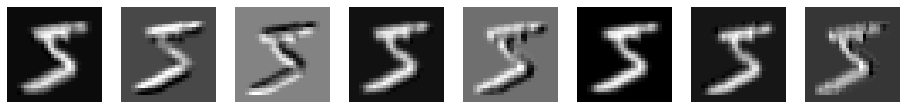

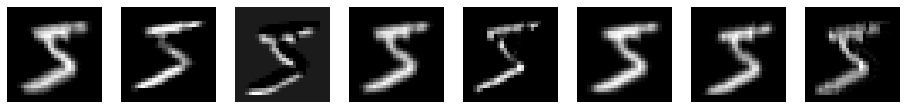

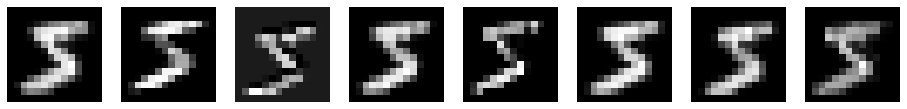

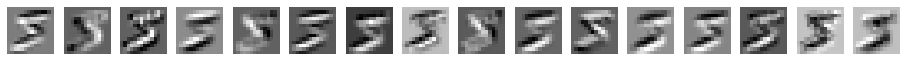

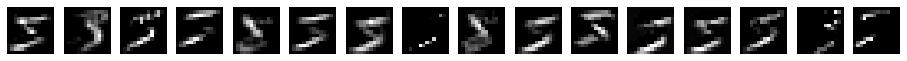

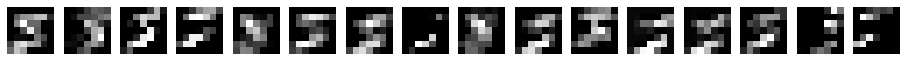

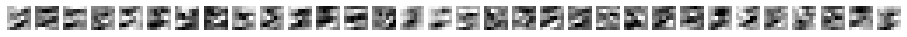

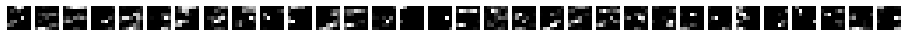

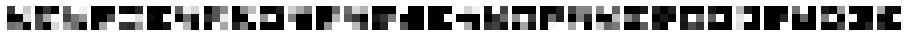

In [ ]:
 show_feature_maps_from_layer(layer_name='conv2d', img=x_train[0][None,:,:,:])
 show_feature_maps_from_layer(layer_name='activation', img=x_train[0][None,:,:,:])
 show_feature_maps_from_layer(layer_name='max_pooling2d', img=x_train[0][None,:,:,:])

 for i in range(1,3):
  show_feature_maps_from_layer(layer_name='conv2d_' + str(i), img=x_train[0][None,:,:,:])
  show_feature_maps_from_layer(layer_name='activation_'+str(i), img=x_train[0][None,:,:,:])
  show_feature_maps_from_layer(layer_name='max_pooling2d_' + str(i), img=x_train[0][None,:,:,:])

In [ ]:
W = model.layers[1].get_weights()[0];
W = W.reshape((28,28,10)) # there are 10 classes and one 28x28 weight image per class
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()
  plt.title(f'Row {i} of W')

Generating a image for prediction

In [ ]:
draw(filename = "drawing.png", w=128, h=128, line_width=10)

1235

In [ ]:
drawing = Image.open('drawing.png')

#Converting the image to RGB instead of RGBA
drawing.load() # required for png.split()
rgb_drawing = Image.new("RGB", drawing.size, (255, 255, 255))
rgb_drawing.paste(drawing, mask=drawing.split()[3]) # 3 is the alpha channel

#Resizing
rgb_drawing = rgb_drawing.resize((28,28)) #Uses PIL to resize

#Converting to numpy object
rgb_drawing = np.array(rgb_drawing)

#Inverting black and white
rgb_drawing = np.invert(rgb_drawing)

#removes the channels
rgb_drawing = rgb_drawing[:,:,0]

plt.imshow(rgb_drawing)

print(rgb_drawing.shape)

FileNotFoundError: ignored

Makes the dimensions 'eatable' for the network

In [ ]:
rgb_drawing = rgb_drawing[None,:,:, None]

In [ ]:
rgb_drawing_prediction = model.predict(rgb_drawing)
print("predictions:",rgb_drawing_prediction)
print("Predicted label:",rgb_drawing_prediction.argmax())
print("Accuracy: ",rgb_drawing_prediction.max())

______________________________________


### Save, convert, Zip and Download

Save and convert

In [ ]:
!pip install tensorflowjs 

     |████████████████████████████████| 64 kB 2.1 MB/s 


In [ ]:
model.save('keras.h5')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

Crating the class_names file

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[('9', 0.4934231), ('5', 0.28210795), ('7', 0.099437855), ('4', 0.08925793), ('8', 0.022779651)]


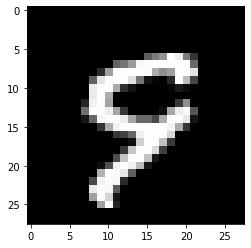

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
class_names = []
for i in range(10): class_names.append(str(i));
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze(),cmap='gray') 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [(class_names[x],pred[x]) for x in ind]
print(y_test[idx])
print(latex)

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

Zip and download

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 63%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/class_names.txt (stored 0%)


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Trying with a data generator

https://towardsdatascience.com/image-data-generators-in-keras-7c5fc6928400

In [ ]:
#Import the required libaries
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline

In [ ]:
batch_size=32
datagen_args = dict(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
                   rescale=1./255)
datagen = ImageDataGenerator(**datagen_args)
datagenerator = datagen.flow(x_train,y_train,
                                            batch_size=batch_size,shuffle=True)


In [ ]:
x,y = next(datagenerator)
print("x:", type(x))
print("y:", type(x))
print("x:", x.shape)
print("y:", y.shape)


x: <class 'numpy.ndarray'>
y: <class 'numpy.ndarray'>
x: (32, 28, 28, 1)
y: (32, 10)


Testing if the generator works

In [ ]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
    #     if show_labels:
    #         #ax.set_title(class_mapping[y_int[i]])
    #         print("hej")
    # if savename != None:
    #     plt.savefig(savename,bbox_inches='tight')

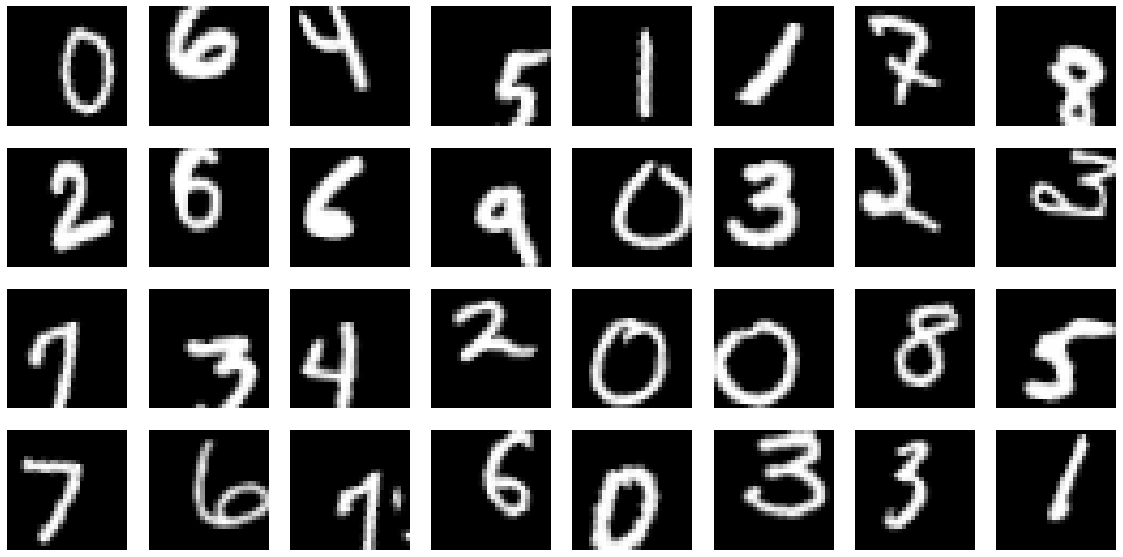

In [ ]:
show_grid(x,4,8,figsize=(20,10))

Testing the generator


In [ ]:
model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.1), loss='categorical_crossentropy',metrics=['accuracy'])


###Training

In [ ]:

epochs = 10
hist = model.fit_generator(datagenerator, 
                           steps_per_epoch= math.ceil(len(datagenerator.x)//batch_size),
                           epochs=epochs, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1875/1875 [==============================] - 62s 17ms/step - loss: 2.3020 - accuracy: 0.1103
Epoch 2/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3020 - accuracy: 0.1096
Epoch 3/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3020 - accuracy: 0.1108
Epoch 4/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3020 - accuracy: 0.1112
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3020 - accuracy: 0.1102
Epoch 6/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3019 - accuracy: 0.1113
Epoch 7/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3019 - accuracy: 0.1125
Epoch 8/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3019 - accuracy: 0.1116
Epoch 9/10
1875/1875 [==============================] - 33s 18ms/step - loss: 2.3019 - accuracy: 0.1113
Epoch 10/10
1875/1875 [==============================] - 33s 17m

In [ ]:
y = model.predict_generator(x_test, steps= math.ceil(dgen_no_shuffle.samples//batch_size))

AttributeError: ignored

Testing the model

In [ ]:
draw(filename = "drawing.png", w=128, h=128, line_width=10)

1574

In [ ]:
def predict_drawing():
  #Opening the image
  png = Image.open('drawing.png')

  #Converting the image to RGB instead of RGBA
  png.load() # required for png.split()
  rgb_image = Image.new("RGB", png.size, (255, 255, 255))
  rgb_image.paste(png, mask=png.split()[3]) # 3 is the alpha channel

  #Resizing
  rgb_image = rgb_image.resize((28,28)) #Uses PIL to resize

  #Converting to numpy object
  numpy_image = np.array(rgb_image)

  #Inverting black and white
  numpy_image = np.invert(numpy_image)

  #Removes the channels
  numpy_image = numpy_image[:,:,0]

  #Plotting the image
  plt.imshow(numpy_image)
  plt.figure()

  #Adding the dimension for number of example
  numpy_image = numpy_image[None,:,:]

  #nomalizing
  numpy_image = numpy_image.astype('float32')
  numpy_image /= 255

  drawedImagePrediction = model.predict(numpy_image[:,:,:,None])

  return drawedImagePrediction;

<Figure size 432x288 with 0 Axes>

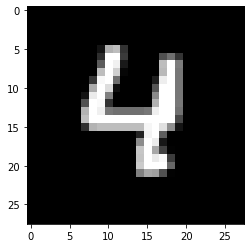

<Figure size 432x288 with 0 Axes>

In [ ]:
#Opening the image
png = Image.open('drawing.png')

#Converting the image to RGB instead of RGBA
png.load() # required for png.split()
rgb_image = Image.new("RGB", png.size, (255, 255, 255))
rgb_image.paste(png, mask=png.split()[3]) # 3 is the alpha channel

#Resizing
rgb_image = rgb_image.resize((28,28)) #Uses PIL to resize

#Converting to numpy object
numpy_image = np.array(rgb_image)

#Inverting black and white
numpy_image = np.invert(numpy_image)

#Removes the channels
numpy_image = numpy_image[:,:,0]

#Plotting the image
plt.imshow(numpy_image)
plt.figure()

In [ ]:
#Adding the dimension for number of example
numpy_image = numpy_image[None,:,:]

In [ ]:
numpy_image = numpy_image.astype('float32')
numpy_image /= 255

In [ ]:
drawedImagePrediction = model.predict(numpy_image[:,:,:,None])

In [ ]:
print("predictions:",drawedImagePrediction)
print("Predicted label:",drawedImagePrediction.argmax())
print("Accuracy: ",drawedImagePrediction.max())

predictions: [[0.12020001 0.12770355 0.09405863 0.10259294 0.08390177 0.08715308
  0.09660147 0.0944828  0.10515011 0.08815569]]
Predicted label: 1
Accuracy:  0.12770355


#2nd try with datagenerators

I try using this instead

https://towardsdatascience.com/keras-custom-data-generators-example-with-mnist-dataset-2a7a2d2b0360

In [ ]:
import tensorflow as tf
import os
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import math

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
class DataGenerator(tf.compat.v2.keras.utils.Sequence):
 
    def __init__(self, X_data , y_data, batch_size, dim, n_classes,
                 to_fit, shuffle = True):
        self.batch_size = batch_size
        self.X_data = X_data
        self.labels = y_data
        self.y_data = y_data
        self.to_fit = to_fit
        self.n_classes = n_classes
        self.dim = dim
        self.shuffle = shuffle
        self.n = 0
        self.list_IDs = np.arange(len(self.X_data))
        self.on_epoch_end()
    def __next__(self):
        # Get one batch of data
        data = self.__getitem__(self.n)
        # Batch index
        self.n += 1
        
        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0
        
        return data
    def __len__(self):
        # Return the number of batches of the dataset
        return math.ceil(len(self.indexes)/self.batch_size)
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:
            (index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = self._generate_x(list_IDs_temp)
        
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.X_data))
        
        if self.shuffle: 
            np.random.shuffle(self.indexes)
    def _generate_x(self, list_IDs_temp):
               
        X = np.empty((self.batch_size, *self.dim))
        
        for i, ID in enumerate(list_IDs_temp):
            
            X[i,] = self.X_data[ID]
            
            # Normalize data
            X = (X/255).astype('float32')
            
        return X[:,:,:, np.newaxis]
    def _generate_y(self, list_IDs_temp):
        
        y = np.empty(self.batch_size)
        
        for i, ID in enumerate(list_IDs_temp):
            
            y[i] = self.y_data[ID]
            
        return keras.utils.to_categorical(
                y,num_classes=self.n_classes)

In [ ]:
n_classes = 10
input_shape = (28, 28)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28 , 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
train_generator = DataGenerator(x_train, y_train, batch_size = 64,
                                dim = input_shape,
                                n_classes=10, 
                                to_fit=True, shuffle=True)
val_generator =  DataGenerator(x_test, y_test, batch_size=64, 
                               dim = input_shape, 
                               n_classes= n_classes, 
                               to_fit=True, shuffle=True)

In [ ]:
images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

(64, 28, 28, 1)
(64, 10)


In [ ]:
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator,
        validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
938/938 [==============================] - 43s 13ms/step - loss: 2.3026 - accuracy: 0.1115 - val_loss: 2.3026 - val_accuracy: 0.1136
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 2.3026 - accuracy: 0.1124 - val_loss: 2.3025 - val_accuracy: 0.1134
Epoch 3/10
193/938 [=====>........................] - ETA: 8s - loss: 2.3026 - accuracy: 0.1091

KeyboardInterrupt: ignored

#forsøg 3 hvor jeg kopiere fra lab3

In [ ]:
from __future__ import print_function
from tensorflow import keras
from keras.datasets import cifar10
from keras.datasets import mnist
import tensorflow as tf


# The data, split between train and test sets:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Uncomment below to convert class vectors to binary class matrices.
num_classes = 10 # Number of classes
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
from keras import backend as K
img_rows, img_cols = 28,28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# model = Sequential()
# model.add(Conv2D(8, (3, 3), padding='same', input_shape=(28,28,1)))
# model.add(Activation('relu'))
# model.add(Conv2D(16, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(32, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(256)) # W1*x + b
# model.add(Activation('relu')) # ReLU(W1*x + b)
# model.add(Dropout(0.5))
# model.add(Dense(num_classes)) # W2*x + b
# model.add(Activation('softmax'))  # softmax(W2*x + b)

model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Data preprocessing (normalization)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # 0 ... 1
x_test /= 255

data_augmentation = True
epochs = 2 # You should train for longer
batch_size = 64

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.3,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.3,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

Using real-time data augmentation.


In [ ]:
# Fit the model on the batches generated by datagen.flow().
model.fit(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          workers=4,
          shuffle=True)

Epoch 1/2
938/938 [==============================] - 44s 46ms/step - loss: 2.3048 - accuracy: 0.1066 - val_loss: 2.3032 - val_accuracy: 0.1135
Epoch 2/2
 79/938 [=>............................] - ETA: 38s - loss: 2.3030 - accuracy: 0.1159

KeyboardInterrupt: ignored

In [ ]:
draw(filename = "drawing.png", w=128, h=128, line_width=10)

2080

predictions: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Predicted label: 4
Accuracy:  1.0


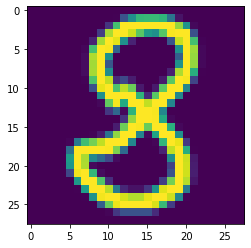

<Figure size 432x288 with 0 Axes>

In [ ]:
a = predict_drawing()
print("predictions:",a)
print("Predicted label:",a.argmax())
print("Accuracy: ",a.max())